# Cross Section Calculation with Cthulhu

This quick start guide demonstrates how Cthulhu offers you the power to download a line list, calculate a high-resolution molecular cross section for a grid of temperatures and pressures, and package the output into a HDF5 opacity database. All on your laptop!

This quick start guide assumes at least a passing familiarity with cross sections (or that the world is ending and you need a cross section ASAP). For complete beginners, we recommend starting with the [Cthulhu tutorials](https://cthulhu.readthedocs.io/en/latest/content/notebooks/temperature_pressure.html).

Here we'll use AlO as an example, since this is a small line list (~ 5 million transitions) that can easily run on a laptop. We recommend running Cthulhu on a laptop for line lists that are less than about ~100 million transitions. For larger line lists, or if you need a very large grid of pressure-temperature calculations, we recommend sacrificing your cluster to Cthulhu (as shown in [our cluster tutorial](https://cthulhu.readthedocs.io/en/latest/content/notebooks/slurm_tutorial.html)).

## Download ExoMol Line List for AlO


In [1]:
from Cthulhu.core import summon

species = 'AlO'          # Chemical species name

database = 'ExoMol'      # Line list Database  
linelist = 'ATP'         # Specific name of the line list for AlO

broadening = 'H2-He'     # Background gas broadening

nu_min = 200             # Minimum wavenumber (1/wavelength) in units of cm^-1
nu_max = 35000           # Maximum wavenumber (1/wavelength) in units of cm^-1

input_directory = './input/'   # Where the line list will be downloaded

Download the AlO line list

In [2]:
summon(database=database, species = species, linelist = linelist)     # Embrace the Old One


 ***** Downloading requested data from ExoMol. You have chosen the following parameters: ***** 

Molecule: AlO 
Isotopologue: 27Al-16O 
Line List: ATP

Starting by downloading the .broad, .pf, and .states files...
Fetched the broadening coefficients, partition functions, and energy levels.
Now downloading the ATP line list...



100%|██████████| 32.6M/32.6M [00:04<00:00, 6.90MiB/s]



Converting this .trans file to HDF to save storage space...
This file took 13.8 seconds to reformat to HDF.

Line list ready.



## Calculate AlO Cross Section

First, let's calculate the cross section of AlO for a single pressure-temperature point to get a handle on the runtime. We'll choose 10 bar and 1000 K.

In [3]:
import numpy as np
from Cthulhu.core import compute_cross_section

P = [1.0]         # Pressure (bar)
T = [1000.0]      # Temperature (K)

# There are many more optional arguments to play with!
compute_cross_section(database = database, species = species, linelist = linelist,
                      pressure = P, temperature = T, S_cut = 0.0,                    # No intensity cut-off (S_cut)
                      input_dir = input_directory,
                      nu_out_min = nu_min, nu_out_max = nu_max, dnu_out = 0.01,      # Wavenumber spacing of 0.01 cm^-1  (R ~ 10^6)
                      broad_type = broadening,
                      verbose = True, N_cores = 4)                                   # Grant the mighty Cthulhu 4 cores  

Beginning cross-section computations...
Loading ExoMol format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 0.383484590012813 s
Pre-computation steps complete
Generating cross section for AlO at P = 1.0 bar, T = 1000.0 K
Computing transitions from ATP.h5 | 0.0% complete
Completed 4943804 transitions in 19.19825641301577 s
Calculation complete!
Completed 4943804 transitions in 19.19919453599141 s

Total runtime: 23.555935014999704 s


We see that AlO only takes about 20 s for a single (P, T) point, so we can easily compute a cross section for a grid of pressures and temperatures on a laptop.

Let's plot the cross section.

/home/ryanmacdonald/code/Cthulhu/Cthulhu/plot.py:152: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([1e4/nu_max, 1e4/nu_min]) # Convert wavenumber (in cm^-1) to wavelength (in um)


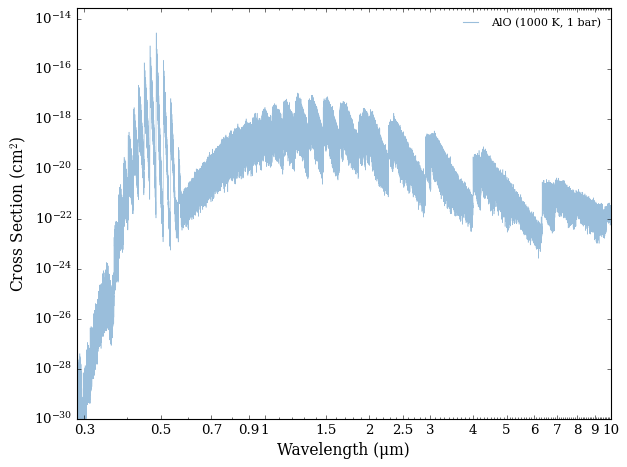

In [4]:
from Cthulhu.misc import read_cross_section_file, cross_section_collection
from Cthulhu.plot import plot_cross_section

'''Read in the cross section we just computed'''

# Read in cross section
nu, sigma = read_cross_section_file(species = species, database = database, ionization_state = 1,
                                    filename = species + '_T' + str(T[0]) + 
                                    'K_log_P' + str(round(np.log10(P[0]), 1)) + '_' + broadening + '_sigma.txt')

cross_sections = []

# Add first cross section to collection
cross_sections = cross_section_collection(new_x = nu, new_y = sigma, collection = cross_sections)

plot_cross_section(collection = cross_sections, labels = [species + ' (1000 K, 1 bar)'], 
                    filename = species, y_min = 1e-30, x_max = 10, save_fig = False)

Looking good! Now let's iterate over pressures and temperatures to generate a full AlO cross section.

#### Full cross section calculation

We'll calculate the AlO cross section for the 162 pressure-temperature points used by the [POSEIDON](https://poseidon-retrievals.readthedocs.io/en/latest/) atmospheric retrieval code.

The code below will take about an hour to run.

In [5]:
from Cthulhu.core import compute_cross_section

P = [1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0e0, 1.0e1, 1.0e2]    # Pressure (bar)
log_P = [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]                  # log10 pressure
T = [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0,                 # Temperature (K)
     900.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0,
     2500.0, 3000.0, 3500.0]

compute_cross_section(database = database, species = species, linelist = linelist,
                      pressure = P, temperature = T, S_cut = 0.0,
                      input_dir = input_directory,
                      nu_out_min = nu_min, nu_out_max = nu_max, dnu_out = 0.01,
                      broad_type = broadening,
                      verbose = True, N_cores = 4)

Beginning cross-section computations...
Loading ExoMol format
Loading partition function
Pre-computing Voigt profiles...
Voigt profiles computed in 0.06449141199118458 s
Pre-computation steps complete
Generating cross section for AlO at P = 1e-06 bar, T = 100.0 K   [1 of 162]
Computing transitions from ATP.h5 | 0.0% complete
Completed 4943804 transitions in 4.868555976980133 s
Calculation complete!
Completed 4943804 transitions in 4.869067308987724 s

Pre-computing Voigt profiles...
Voigt profiles computed in 0.061304300994379446 s
Pre-computation steps complete
Generating cross section for AlO at P = 1e-06 bar, T = 200.0 K   [2 of 162]
Computing transitions from ATP.h5 | 0.0% complete
Completed 4943804 transitions in 6.536610487994039 s
Calculation complete!
Completed 4943804 transitions in 6.537135604012292 s

Pre-computing Voigt profiles...
Voigt profiles computed in 0.057716253999387845 s
Pre-computation steps complete
Generating cross section for AlO at P = 1e-06 bar, T = 300.0 K 

## Plot Computed Cross Section

We'll now plot two temperatures and pressures to show the T and P dependences of AlO's cross section.

/home/ryanmacdonald/code/Cthulhu/Cthulhu/plot.py:152: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([1e4/nu_max, 1e4/nu_min]) # Convert wavenumber (in cm^-1) to wavelength (in um)


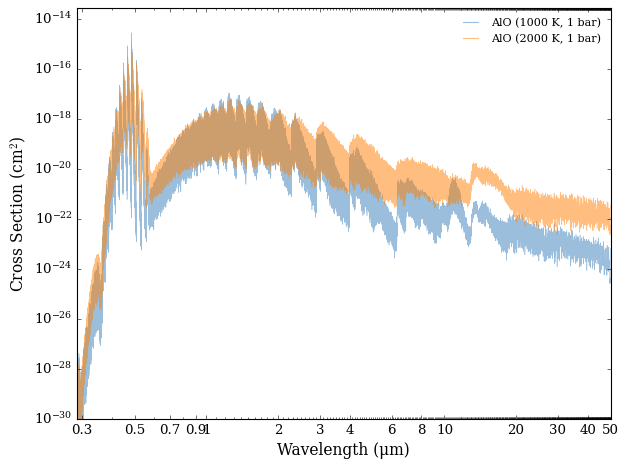

In [6]:
from Cthulhu.misc import read_cross_section_file, cross_section_collection
from Cthulhu.plot import plot_cross_section

# Read in cross section at 1000 K
nu, sigma = read_cross_section_file(species = species, database = database, 
                                    filename = species + '_T1000.0K_log_P0.0_' + broadening + '_sigma.txt')

# Read in cross section at 2000 K
nu2, sigma2 = read_cross_section_file(species = species, database = database,
                                        filename = species + '_T2000.0K_log_P0.0_' + broadening + '_sigma.txt')

# Add both cross sections to collection in preparation for plotting

cross_sections = []

# Add first cross section to collection
cross_sections = cross_section_collection(new_x = nu, new_y = sigma, collection = cross_sections)

# Add second cross section to collection, making sure to specify the previous collection as a parameter
cross_sections = cross_section_collection(new_x = nu2, new_y = sigma2, collection = cross_sections)

plot_cross_section(collection = cross_sections, labels = [species + ' (1000 K, 1 bar)', species + ' (2000 K, 1 bar)'], 
                    filename = species + '_Temperature', y_min = 1.0e-30)

/home/ryanmacdonald/code/Cthulhu/Cthulhu/plot.py:152: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([1e4/nu_max, 1e4/nu_min]) # Convert wavenumber (in cm^-1) to wavelength (in um)


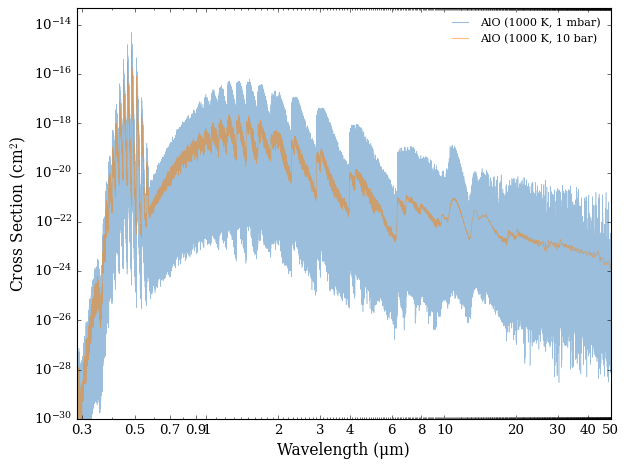

In [7]:
# Read in cross section at 1 mbar
nu, sigma = read_cross_section_file(species = species, database = database, 
                                    filename = species + '_T1000.0K_log_P-3.0_' + broadening + '_sigma.txt')

# Read in cross section at 10 bar
nu2, sigma2 = read_cross_section_file(species = species, database = database,
                                        filename = species + '_T1000.0K_log_P1.0_' + broadening + '_sigma.txt')

cross_sections = []

# Add first cross section to collection
cross_sections = cross_section_collection(new_x = nu, new_y = sigma, collection = cross_sections)

# Add second cross section to collection, making sure to specify the previous collection as a parameter
cross_sections = cross_section_collection(new_x = nu2, new_y = sigma2, collection = cross_sections)

plot_cross_section(collection = cross_sections, labels = [species + ' (1000 K, 1 mbar)', species + ' (1000 K, 10 bar)'], 
                    filename = species + '_Pressure', y_min = 1.0e-30)

## Create an Opacity Database

### Package the cross section grid as a HDF5 file

By default, Cthulhu writes the cross section for each (P,T) pair as a .txt file in the ./output folder. 

We'll now combine all of the different (P,T) pairs into a single HDF5 file for storage efficiency and fast read time.

In [8]:
from Cthulhu.hdf5_package import make_single_species_HDF5

P = [1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0e0, 1.0e1, 1.0e2]    # Pressure (bar)
log_P = [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]                  # log10 pressure
T = [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0,                 # Temperature (K)
     900.0, 1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0,
     2500.0, 3000.0, 3500.0]

make_single_species_HDF5(species, database = database, linelist = linelist, 
                         log_P = log_P, T = T, isotope = 'default', 
                         broadening = broadening, output_dir = './output/HDF5/')

Now preparing HDF5 file for: AlO


Progress: 100%|██████████| 162/162 [06:12<00:00,  2.30s/it]


AlO done


#### Combining different chemical species into an opacity database

Once you have made the HDF5 file for a single chemical species, you can add it into an opacity database HDF5 file which can contain the cross sections for multiple gases.

In [9]:
from Cthulhu.hdf5_package import extend_HDF5_database

database_name = 'Combined_Opacity_database.hdf5'   # If this database file doesn't already exist, Cthulhu will create the file

extend_HDF5_database(database_name, species)     # Calling this function for other gases will add them to the database

AlO done


Let's print the attributes of our new opacity database.

In [10]:
import h5py

def print_attrs(name, obj):
    """Print attributes of an HDF5 object."""
    print(name)
    for key, val in obj.attrs.items():
        print(f"  {key}: {val}")

def list_all_attributes(filename):
    """List all attributes in an HDF5 file."""
    with h5py.File(filename, 'r') as f:
        f.visititems(print_attrs)

list_all_attributes('./Combined_Opacity_database.hdf5')

AlO
  Broadening: H2-He
  Linelist: ATP
  Modified: 2024-08-07
  Source: ExoMol
  Version: v1
AlO/T
  Units: K
  Variable: Temperature
AlO/log(P)
  Units: log10(P/bar)
  Variable: Pressure (log10 scale)
AlO/log(sigma)
  Units: log10(sigma/m^2)
  Variable: Cross section (log10 scale)
AlO/nu
  Units: cm^-1
  Variable: Wavenumber


Congratulations, you've made your fitst opacity database! 🎉

You can now use this HDF5 file with your favourite exoplanet or brown dwarf modelling code.